In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import torch
import autograd.numpy as np
import autograd.scipy.stats as stats
import scipy.optimize as optimize
from autograd.scipy.linalg import logm
from autograd import grad, jacobian
import numpy
import scipy

# Week 3 code

In [2]:
def log_likelihood(y, theta, d):
    likelihood_cov = np.mean(np.square(y[0].T - theta.T @ d.T)) * np.eye(len(d))
    likelihood_mean = d @ theta
    return stable_multivariate_gaussian_logpdf(y[0].T, likelihood_mean, likelihood_cov)
def stable_multivariate_gaussian_logpdf(x, mu, cov):
    n = len(x)
    x_mu = x - mu
    try:
        _, log_det = np.linalg.slogdet(cov)
        cov_inv = np.linalg.inv(cov)
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + np.dot(x_mu, np.dot(cov_inv, x_mu)))
    except np.linalg.LinAlgError:
        cov_modified = cov + np.eye(n) * 1e-8
        _, log_det = np.linalg.slogdet(cov_modified)
        cov_inv = np.linalg.inv(cov_modified)
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + np.dot(x_mu, np.dot(cov_inv, x_mu)))
    return log_prob


def KLD(mean_q, A_q, mean_p, A_p):
    sigma_q = (A_q @ A_q.T)
    sigma_p = (A_p @ A_p.T)
    bar_sigma_q = np.linalg.norm(sigma_q)
    bar_sigma_p = np.linalg.norm(sigma_p)
    k = len(mean_q)
    return 0.5 * (np.trace(np.linalg.inv(sigma_p) @ sigma_q) + (mean_p - mean_q).T @ np.linalg.inv(sigma_p) @ (mean_p - mean_q) - k + np.log(bar_sigma_p/bar_sigma_q))

def theta_to_params(theta):
    shape = len(theta)
    mean_shape = int(shape/3)
    A_shape = (int(np.sqrt(shape - mean_shape)), int(np.sqrt(shape - mean_shape)))
    mean = theta[0:mean_shape]
    A = theta[mean_shape:shape].reshape(A_shape)
    return mean, A

def params_to_theta(mean, A):
    return np.array(list(mean) + list(A.flatten()))

def elbo(mean, A, y, d):
    shape = d.shape[1]
    values = []
    while len(values) < 100:
        sample = np.random.multivariate_normal(np.zeros(shape), np.eye(shape))
        theta = mean + A @ sample
        lik = log_likelihood(y, theta, d)
        if np.any(np.isinf(lik)):
            print('Skipped due to -inf found')
            continue
        values.append(lik)
    return 1/(len(values))*np.sum(values) - KLD(mean, A, mean_prior, A_prior)

# Important assumptions

In [3]:
A_prior = np.array([[3.2, 1.6], [1.1, 2.9]])
mean_prior = np.array([2, 5])
cov_prior = A_prior @ A_prior.T

# Utility functions needed

## ~Likelihood~
$$p(\textbf{y}| \theta_i, \textbf{d})$$
From PML notes, assumed to be gaussian $\sim \mathcal{N}(\theta^T \textbf{d}, \sigma^2_\textbf{y})$

In [4]:
def likelihood(y, theta, d):
    MSE = np.mean(np.square(y - d @ theta))
    likelihood_cov = MSE * np.eye(len(d))
    likelihood_mean = d @ theta
    return np.exp(stable_multivariate_gaussian_logpdf(y, likelihood_mean, likelihood_cov))

In [ ]:
#likelihood(np.array([2,2]), np.array([2, 2, 0, 0, 0, 0]), np.array([1, 1.2]))

## ~Prior~
$$p(\theta_i)$$
Assumed to be gaussian

In [5]:
def prior(theta):
    mean, A = theta_to_params(theta)
    return np.exp(stable_multivariate_gaussian_logpdf(mean, mean_prior, cov_prior))

In [ ]:
#prior(np.array([2, 5, 0, 0, 0, 0]))

## Optimizer for posterior

In [6]:
def optimizer(f, x0, gradient, callback=lambda x: x, rate=0.5, iters=1e5):
    x = x0
    running_average = []
    for i in range(int(iters)):
        r = rate/(1+i*1e-1)
        print('------')
        print(r)
        g = gradient(x)
        print(np.linalg.norm(g))
        x = -g * r + x
        if i % 1 == 0:
            if not callback(x):
                break
    return x

# Log-Posterior
$$\log p(\theta_i | \textbf{y}, \textbf{d})$$
We try to approximate this by our variational distribution $q(\theta) \sim \mathcal{N}(\mu_\theta, \Sigma_\theta)$ such that $$p(\theta_i | \textbf{y}, \textbf{d}) \approx \mathcal{N}(\theta_i, \mu_\theta, \Sigma_\theta)$$.
Thus we first optimize to find $\mu_\theta$ and $\Sigma_\theta$ and then we evalute it.

In [7]:
cached_mean = None
cached_A = None

In [8]:
thetas = []
def log_posterior(weights, y, d, mean0=mean_prior, A0 = A_prior):
    def objective_f(x):
        mean, A = theta_to_params(x)
        return - elbo(mean, A, y, d) + np.linalg.norm(x)
    def callback(xi):
        mean, A = theta_to_params(xi)
        #print(np.linalg.norm(gradient(xi)))
        thetas.append(mean)
        if np.linalg.norm(gradient(xi)) < 7 and np.mean(np.square(y - d @ mean)) < 1:
            return False
        return True
    gradient = grad(objective_f)
    results = optimizer(objective_f, params_to_theta(mean0, A0), gradient, callback=callback, rate=0.5)
    mean, A = theta_to_params(results)
    cached_mean = mean
    cached_A = A
    return stable_multivariate_gaussian_logpdf(weights, mean, A @ A.T), results

In [59]:
thetas = []
xs = np.array([np.linspace(0, 100, 20), np.ones(20)]).T
ys = np.array([[2,1]]) @ xs.T
res, x = log_posterior(mean_prior, ys, xs, mean0=cached_mean, A0=cached_A)
mean, A = theta_to_params(x)
cached_mean = mean
cached_A = A

------
0.5
7.996102188081079
------
0.45454545454545453
9.645228459317371
------
0.4166666666666667


KeyboardInterrupt: 

In [52]:
d_ = 2
l = 300
np.random.seed(612635)
true_weights = np.array([-9, 15])

noise = 2

d = np.random.rand(l)
ones = np.ones((d.shape[0], 1))
d = np.concatenate((np.reshape(d, (d.shape[0], 1)), ones), axis=1)
y = np.random.normal(loc = 0, scale=2, size=l).reshape([l, 1]) + true_weights[0] * d[:, 0].reshape([l,1]) + true_weights[1]
log_posterior(mean_prior, y, d)

------
0.5
291.8199843617202


KeyboardInterrupt: 

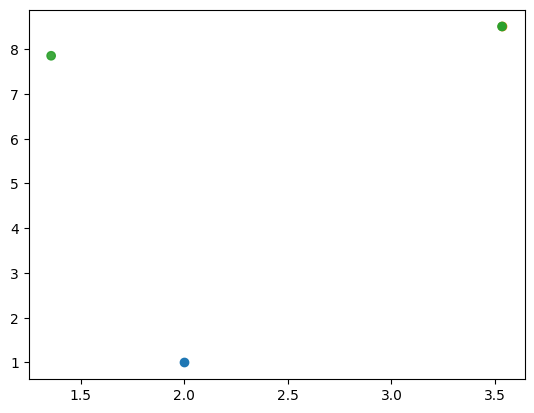

In [49]:
plt.scatter([2], [1])
plt.scatter(thetas[0][0], thetas[0][1])
plt.scatter(np.array(thetas)[:, 0], np.array(thetas)[:, 1], alpha=[10/(10 + i) for i, t in enumerate(thetas)])

# Gradient of Log-Likelihood
$$\frac{\partial }{\partial \textbf{d}} \log p(\theta_i | \textbf{y}, \textbf{d})$$
$$= c + \frac{1}{N}\sum_{i=1}^Np(\textbf{y}|\theta_i, \textbf{d})p(\theta_i)\frac{\partial }{\partial \textbf{d}}\log p(\theta_i |\textbf{y}, \textbf{d})(\log p(\theta_i |\textbf{y}, \textbf{d}) + 1)$$
Based on Lorraine19

In [79]:
def grad_log_likelihood(log_q, theta_i, y, d):
    # samples = 20
    # theta_samples = np.random.multivariate_normal(mean_prior, A_prior @ A_prior.T, size=samples)
    return grad(log_q(theta_i))()

In [80]:
grad_log_likelihood(1,ys,xs)

1.5846827743834317e-46